*   Nama : Ilham Oktavian
*   Dataset : Rice_Image_Dataset.zip
*   Link Dataset : https://www.muratkoklu.com/datasets/Rice_Image_Dataset.zip

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import zipfile, os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dense, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import warnings

In [12]:
# Extract the zip file
local_zip = './drive/MyDrive/Rice_Image_Dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [13]:
# Define directories for different rice varieties
base_dir = '/tmp/Rice_Image_Dataset'
rice_varieties = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
directories = [os.path.join(base_dir, variety) for variety in rice_varieties]

In [14]:
# Count the number of images in each directory
total_counts = [len(os.listdir(directory)) for directory in directories]

# Print the total number of images for each rice variety
for variety, count in zip(rice_varieties, total_counts):
    print(f"Total Data {variety} Image: {count}")

Total Data Arborio Image: 15000
Total Data Basmati Image: 15000
Total Data Ipsala Image: 15000
Total Data Jasmine Image: 15000
Total Data Karacadag Image: 15000


In [15]:
# ImageDataGenerator for augmentations
val_size = 0.2

datagen = ImageDataGenerator(
    rotation_range=30,
    brightness_range=[0.2, 1.0],
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    rescale=1./255,
    validation_split=val_size
)

In [16]:
# Train and Validation generators
train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=128,
    shuffle=True,
    subset="training"
)

validation_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=128,
    shuffle=False,
    subset="validation"
)

Found 60000 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.


In [24]:
# Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(axis=3),
    MaxPooling2D(pool_size=(2, 2), padding='same'),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(axis=3),
    MaxPooling2D(pool_size=(2, 2), padding='same'),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(axis=3),
    MaxPooling2D(pool_size=(2, 2), padding='same'),
    Dropout(0.5),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(5, activation='softmax')
])

In [25]:
# Model Compilation
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 batch_normalization_7 (Bat  (None, 148, 148, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_7 (Conv2D)           (None, 148, 148, 32)      9248      
                                                                 
 batch_normalization_8 (Bat  (None, 148, 148, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                      

**Callbacks**

In [28]:
# Callbacks
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

checkpointer = ModelCheckpoint(filepath='saved_models/model.hdf5',
                               monitor='val_accuracy', mode='max',
                               verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)
callbacks = [early_stopping, reduce_lr, checkpointer]

In [29]:
# Model Training
history = model.fit(train_generator, epochs=40, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/40
469/469 [==============================] - ETA: 0s - loss: 0.2727 - accuracy: 0.8996
Epoch 1: val_accuracy improved from -inf to 0.20893, saving model to saved_models/model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


469/469 [==============================] - 644s 1s/step - loss: 0.2727 - accuracy: 0.8996 - val_loss: 4.7552 - val_accuracy: 0.2089 - lr: 0.0010
Epoch 2/40
469/469 [==============================] - ETA: 0s - loss: 0.0791 - accuracy: 0.9729
Epoch 2: val_accuracy improved from 0.20893 to 0.96507, saving model to saved_models/model.hdf5
469/469 [==============================] - 635s 1s/step - loss: 0.0791 - accuracy: 0.9729 - val_loss: 0.1203 - val_accuracy: 0.9651 - lr: 0.0010
Epoch 3/40
469/469 [==============================] - ETA: 0s - loss: 0.0562 - accuracy: 0.9811
Epoch 3: val_accuracy did not improve from 0.96507
469/469 [==============================] - 599s 1s/step - loss: 0.0562 - accuracy: 0.9811 - val_loss: 1.8216 - val_accuracy: 0.7359 - lr: 0.0010
Epoch 4/40
469/469 [==============================] - ETA: 0s - loss: 0.0450 - accuracy: 0.9848
Epoch 4: val_accuracy did not improve from 0.96507
469/469 [==============================] - 597s 1s/step - loss: 0.0450 - accura

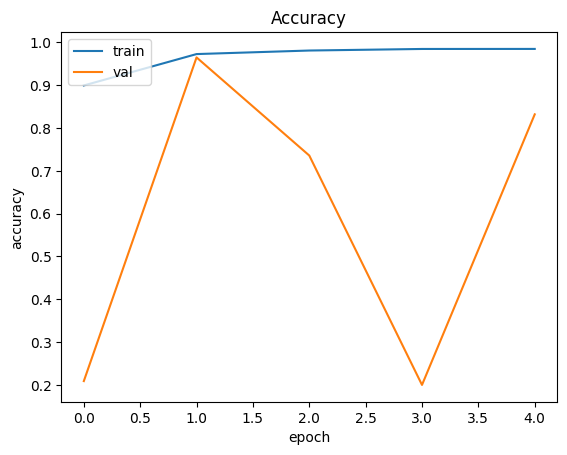

In [30]:
# Plot accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

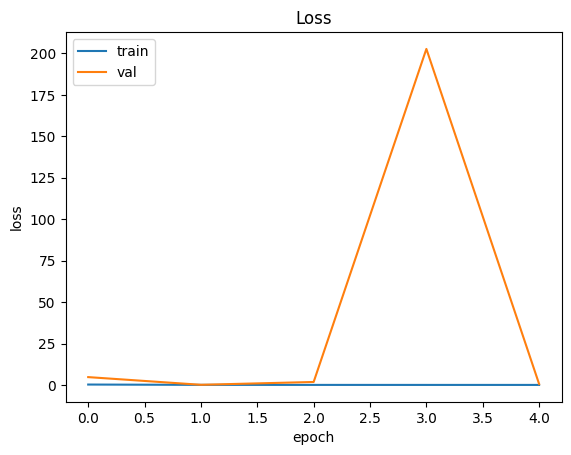

In [31]:
# Plot loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [32]:
# TensorFlow Lite Conversion
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
    f.write(tflite_model)